In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from common_dse import fetch_data, get_backtest_result, get_hodl_result, max_drawdown, sharpe_ratio, save_cache_data, load_cache_data

In [2]:
# Compute funding rate PNL with only one market
exchanges_market = {
    "binance": "XRPUSDT",
    "bitmex": "XRPUSD",
    "apollox": "XRPUSDT",
    "drift": "XRP-PERP",
}
benchmark_exchange = "binance"
benchmark_market = exchanges_market[benchmark_exchange]
market_name = exchanges_market[benchmark_exchange].replace('USDT', '')

# Initial variables
min_time = datetime.fromisoformat('2023-08-01').timestamp()
max_time = datetime.fromisoformat('2024-02-29').timestamp()

data_df_map = {}
results = {}

leverage = 1

# Read data from file
for exchange, market in exchanges_market.items():
    data_df = load_cache_data(exchange, market)
    data_df_map[exchange] = data_df

# calculate min max time
for exchange, market in exchanges_market.items():
    data_df = data_df_map[exchange]
    min_time = max(min_time, data_df["timestamp"].min())
    max_time = min(max_time, data_df["timestamp"].max())

# Calculate funding rate backtest result
for exchange, market in exchanges_market.items():
    data_df = data_df_map[exchange]
    data_df['datetime'] = data_df['datetime'].apply(lambda x: pd.to_datetime(x))

    data_df = data_df[
        (data_df["timestamp"] >= min_time) & (data_df["timestamp"] <= max_time)
    ]

    data_df = data_df.sort_values(by='datetime', ascending=True)
    data_df = data_df.reset_index(drop=True)

    result_df = get_backtest_result(data_df, leverage)
    results[exchange] = result_df

hodl_df = get_hodl_result(results[benchmark_exchange])

# Results are store in 'results' and 'hodl_df' variables

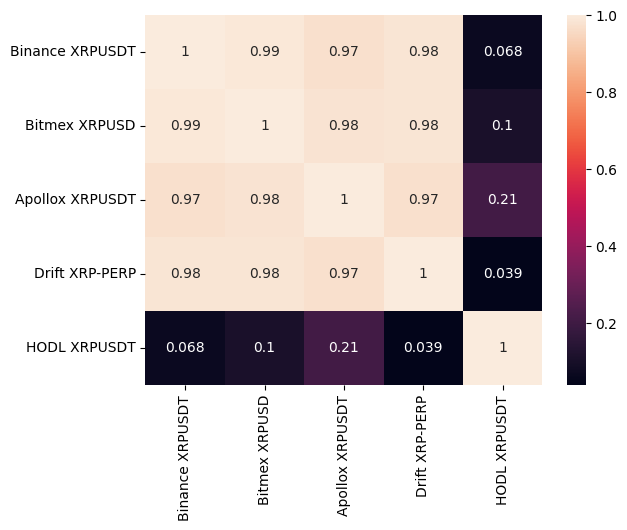

In [4]:
import seaborn as sns

data = {}

# This is used for expanding data in exchanges with 8 hour period to 1 hour period
period = 8

for exchange, market in exchanges_market.items():
    key = f"{exchange.capitalize()} {market}"
    data[key] = results[exchange]['final_pnl']
    if exchange != "drift":
        data[key] = data[key].repeat(period).shift(periods=-period + 1).reset_index(drop=True) / period

data[f"HODL {benchmark_market}"] = hodl_df['pnl'].repeat(period).shift(periods=-period + 1).reset_index(drop=True)
    
corr_df = pd.DataFrame(data)
corr_df.dropna(inplace=True)

correlation_matrix = corr_df.corr()

cmap = "Greys"
sns.heatmap(correlation_matrix, annot=True)
# plt.title("Funding rate arbitrage and HODL Correlation")

plt.savefig(f'./figs/corr_{market_name}.png', format='png', dpi=300, bbox_inches='tight')
correlation_matrix.to_csv(f'./output/corr_{market_name}.csv')
    
plt.show()